In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [17]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Define the source and destination folders
# src_folder = 'TrafficSign\Train'
# train_dst_folder = 'Train_split'
# val_dst_folder = 'Validation_split'

# # Define the split ratio (e.g., 0.8 for 80% training data)
# split_ratio = 0.8

# # Loop through each label folder in the source folder
# for label in os.listdir(src_folder):
#     # Get the list of images in the label folder
#     images = os.listdir(os.path.join(src_folder, label))
    
#     # Split the images into training and validation sets
#     train_images, val_images = train_test_split(images, train_size=split_ratio, random_state=42)
    
#     # Create the label folders in the destination folders
#     os.makedirs(os.path.join(train_dst_folder, label), exist_ok=True)
#     os.makedirs(os.path.join(val_dst_folder, label), exist_ok=True)
    
#     # Move the images to their corresponding folders
#     for image in train_images:
#         shutil.move(os.path.join(src_folder, label, image), os.path.join(train_dst_folder, label))
#     for image in val_images:
#         shutil.move(os.path.join(src_folder, label, image), os.path.join(val_dst_folder, label))

In [19]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dir = "TrafficSign\Train"
validation_dir = "TrafficSign\Validation"
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)


<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\V'
<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:5: SyntaxWarning: invalid escape sequence '\V'
C:\Users\PC\AppData\Local\Temp\ipykernel_13680\2090480049.py:4: SyntaxWarning: invalid escape sequence '\T'
  train_dir = "TrafficSign\Train"
C:\Users\PC\AppData\Local\Temp\ipykernel_13680\2090480049.py:5: SyntaxWarning: invalid escape sequence '\V'
  validation_dir = "TrafficSign\Validation"


Found 31367 files belonging to 43 classes.
Found 7842 files belonging to 43 classes.


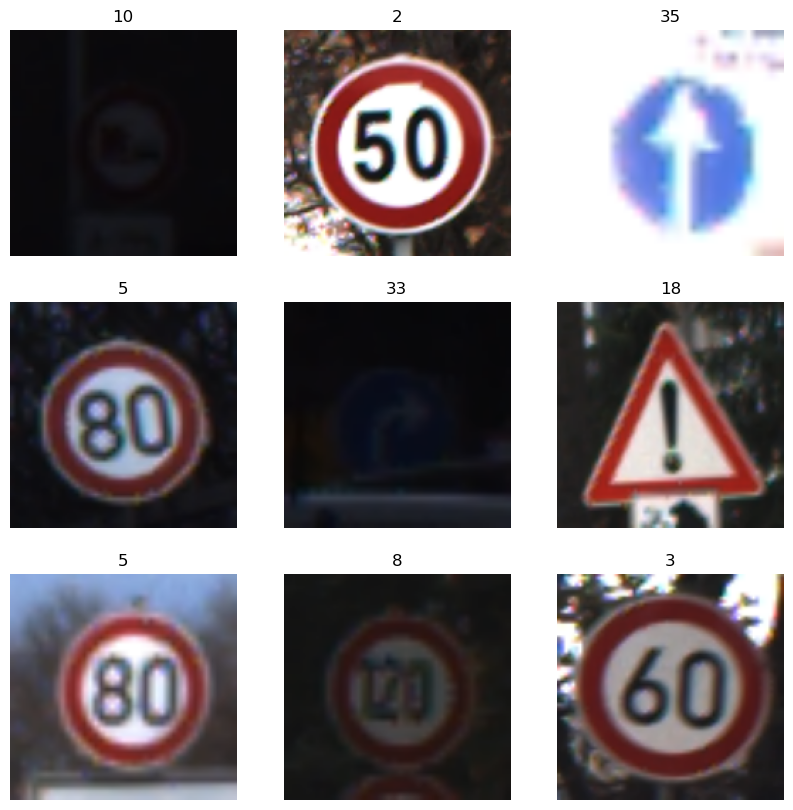

In [21]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [29]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [33]:
 tf.data.experimental.cardinality(train_dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=981>

In [32]:
 tf.data.experimental.cardinality(test_dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=49>

In [31]:

 tf.data.experimental.cardinality(validation_dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=197>

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [37]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

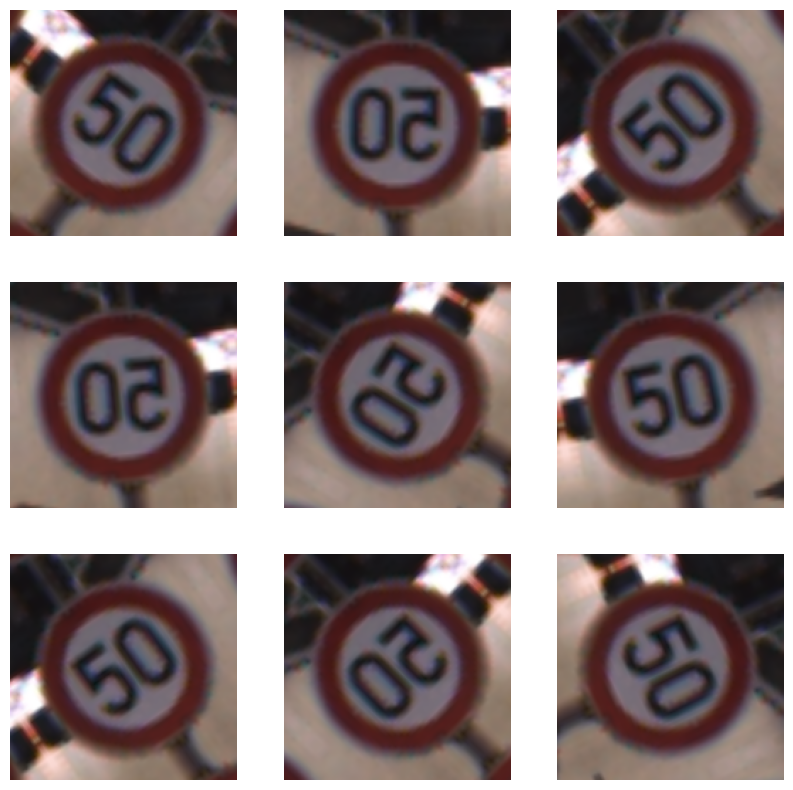

In [40]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [42]:
for image in train_dataset.take(1):
    x = image
    # tf.print(image)

In [77]:
# img = x[0]
img.shape
# img[31][159]

TensorShape([32, 160, 160, 3])

In [72]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### include_top=False: This make sure classification layers are not included from mobilenet

In [74]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [91]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [94]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([33, 34, 18, 16, 42, 12, 12, 18, 41,  5,  5, 18, 38, 32, 34, 12, 38,
        2, 23, 23, 19, 23, 38,  5, 10, 38,  5, 25, 16, 34, 32, 32])>

### This makes sure that all model layers have been frozen

In [86]:
base_model.trainable = False

In [89]:
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 80, 80, 32)        │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 80, 80, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 80, 80, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 80, 80, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 80, 80, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 80, 80, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 80, 80, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 80, 80, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 80, 80, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 80, 80, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 80, 80, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 81, 81, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 40, 40, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [90]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [96]:
prediction_layer = tf.keras.layers.Dense(43, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 43)


In [97]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [98]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 43)                  │          55,083 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,313,067 (8.82 MB)

 Trainable params: 55,083 (215.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [99]:
len(model.trainable_variables)

2

In [105]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [107]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy (),
              metrics=['accuracy']
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 43)                  │          55,083 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,313,067 (8.82 MB)

 Trainable params: 55,083 (215.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [112]:
loss0, accuracy0 = model.evaluate(validation_dataset)

In [113]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.62
initial accuracy: 0.01


In [114]:
initial_epochs = 5
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 258s 263ms/step - accuracy: 0.2239 - loss: 2.9370 - val_accuracy: 0.5196 - val_loss: 1.6468
Epoch 2/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 254s 259ms/step - accuracy: 0.5287 - loss: 1.5529 - val_accuracy: 0.6238 - val_loss: 1.2713
Epoch 3/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 265s 270ms/step - accuracy: 0.6232 - loss: 1.2198 - val_accuracy: 0.6807 - val_loss: 1.0724
Epoch 4/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 254s 259ms/step - accuracy: 0.6685 - loss: 1.0558 - val_accuracy: 0.7182 - val_loss: 0.9475
Epoch 5/5
981/981 ━━━━━━━━━━━━━━━━━━━━ 260s 265ms/step - accuracy: 0.7067 - loss: 0.9362 - val_accuracy: 0.7442 - val_loss: 0.8628


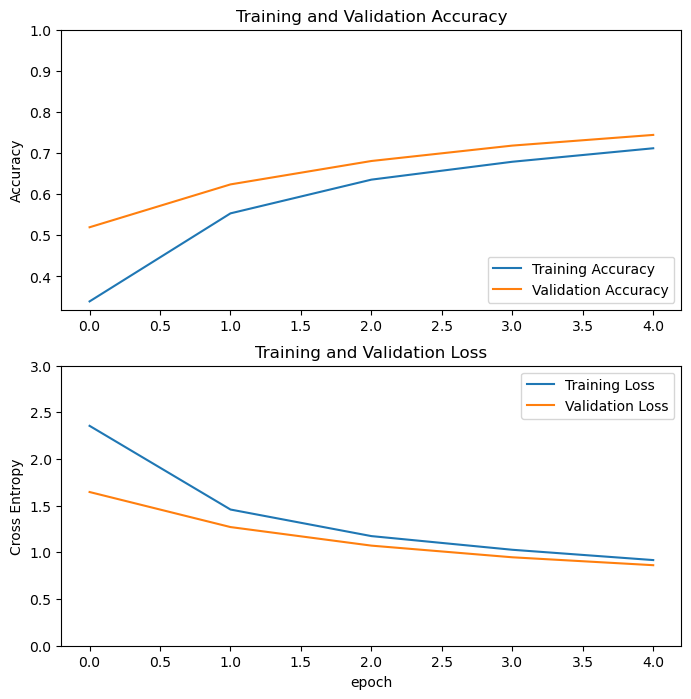

In [121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [123]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 460ms/step - accuracy: 0.7428 - loss: 0.8608
Test accuracy : 0.7487244606018066


In [125]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")

In [126]:
predictions

array([0.00070091, 0.02626728, 0.00335404, ..., 0.01275844, 0.16413707,
       0.09195666], dtype=float32)

<KerasTensor shape=(None, 160, 160, 3), dtype=float32, sparse=None, name=keras_tensor_165>

Predicted classes:
 [ 9  8 12  4  9  3 18  4 32 24 25 23 42 42 38  2 12 25 32 12 41 12 10  4
 16 12 18  4 38  5  4 40]
Labels:
 [ 9  8 12  4  9  3  3  4 32 24 25 23  2  2 38  2 12 25 32 12 41 23 10  4
 16 12 18  4 34 15  4 40]


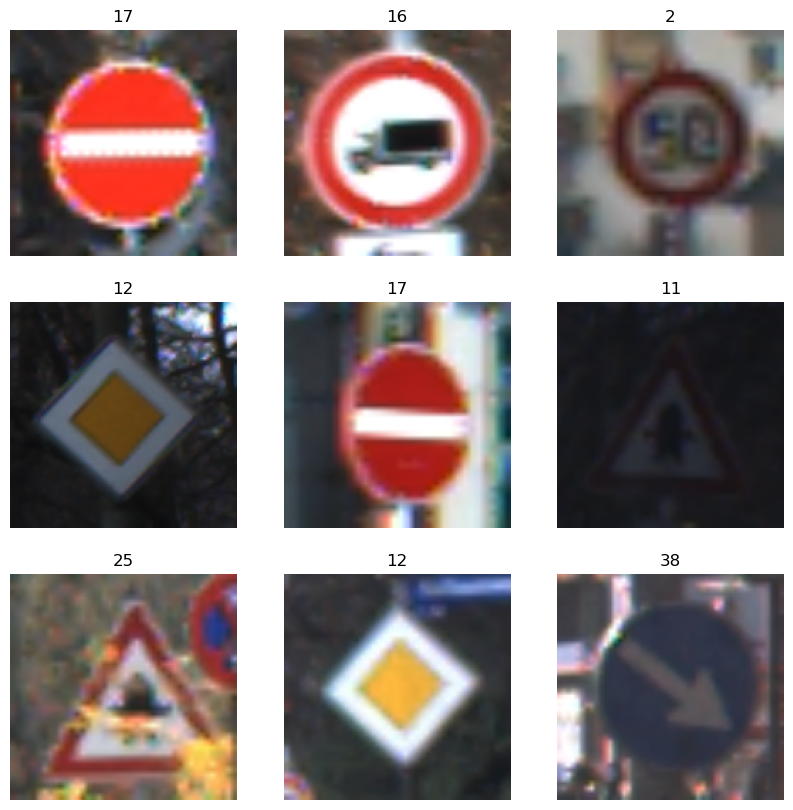

In [127]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Get the predicted class indices
predicted_classes = tf.argmax(predictions, axis=1)

print('Predicted classes:\n', predicted_classes.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predicted_classes[i]])  # Display predicted class name
  plt.axis("off")